In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline


In [2]:
mode= 'bilinear'
width = 32
base_levels = 2
#base_levels = 1.61803
#base_levels = np.sqrt(2)


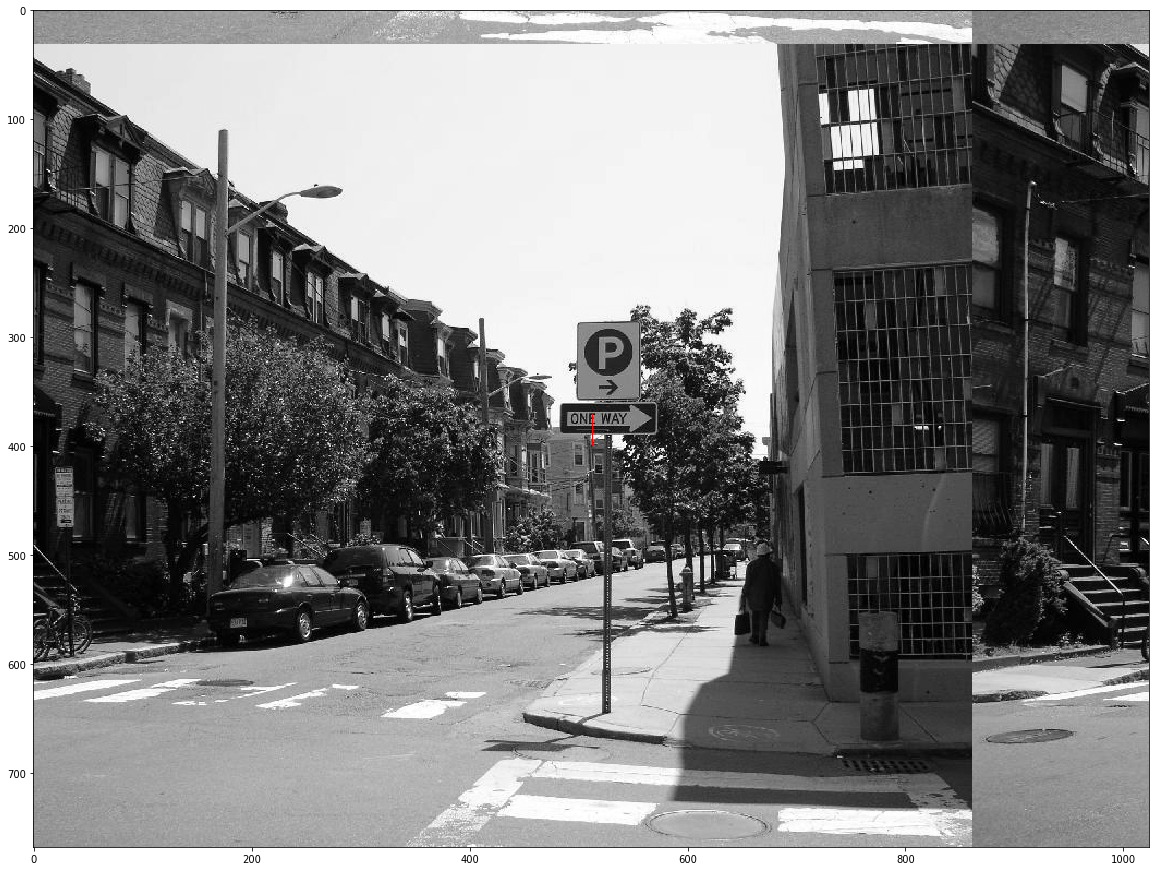

In [3]:
from SLIP import imread
img_orig = imread('../data/homer.jpg')
img_orig = imread('../data/i05june05_static_street_boston_p1010764.jpeg')
img_orig = np.roll(img_orig, -162, axis=1) # sliding gaze to the right by moving image to the left
img_orig = np.roll(img_orig, 32, axis=0) # sliding gaze to the top by moving image to the bottom

from SLIP import Image
pe = {'N_X': img_orig.shape[0], 'N_Y': img_orig.shape[1], 'do_mask': True, 'do_whitening': True,
       'white_n_learning': 0, 'white_N': 0.07, 'white_N_0': 0.0, 'white_f_0': 0.4, 'white_alpha': 1.4,
      'white_steepness': 4.0}

im = Image(pe)
#img_orig = im.whitening(img_orig) * im.mask

fig, ax = plt.subplots(figsize=(20,20))
ax.imshow(img_orig, cmap='gray')
ax.plot([img_orig.shape[1]/2], [img_orig.shape[0]/2], 'r+', ms=32);

# using torch to build up a pyramid

https://pytorch.org/docs/master/nn.functional.html#torch.nn.functional.interpolate

In [4]:
import torch
img_tens = torch.Tensor(img_orig[None, None, ...])
N_X, N_Y = img_tens.shape[-2:]
print('Tensor shape=', img_tens.shape)

Tensor shape= torch.Size([1, 1, 768, 1024])


In [5]:
from torch.nn.functional import interpolate

img_down = img_tens.clone()
n_levels = 1
while max(img_down.shape) > width :
    img_down = interpolate(img_down, scale_factor=1/base_levels, mode=mode)
    n_levels += 1
    print('Tensor shape=', img_down.shape, ', n_levels=', n_levels)

Tensor shape= torch.Size([1, 1, 384, 512]) , n_levels= 2
Tensor shape= torch.Size([1, 1, 192, 256]) , n_levels= 3
Tensor shape= torch.Size([1, 1, 96, 128]) , n_levels= 4
Tensor shape= torch.Size([1, 1, 48, 64]) , n_levels= 5
Tensor shape= torch.Size([1, 1, 24, 32]) , n_levels= 6


Tensor shape= torch.Size([1, 1, 384, 512]) , n_levels= 6
Tensor shape= torch.Size([1, 1, 192, 256]) , n_levels= 6
Tensor shape= torch.Size([1, 1, 96, 128]) , n_levels= 6
Tensor shape= torch.Size([1, 1, 48, 64]) , n_levels= 6
Tensor shape= torch.Size([1, 1, 24, 32]) , n_levels= 6


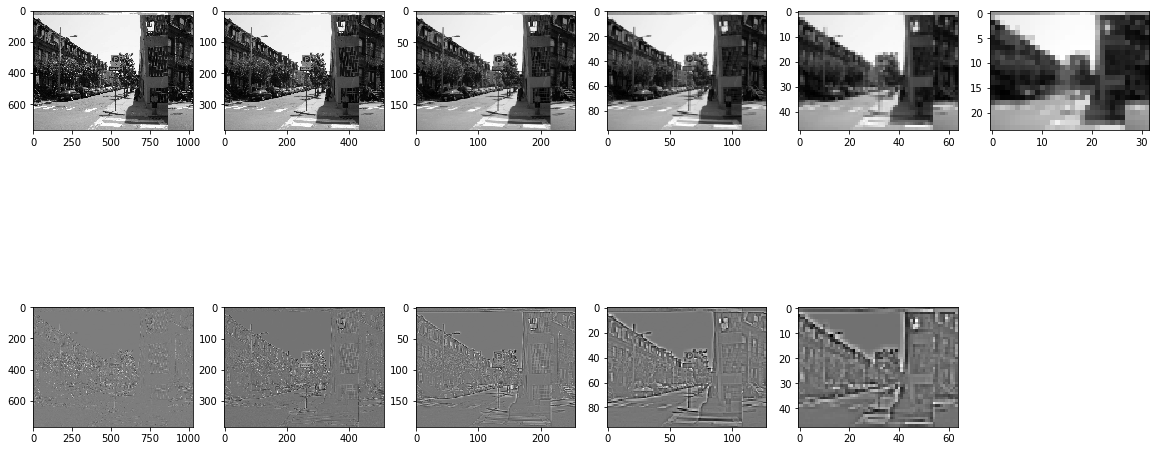

In [6]:
img_down = img_tens.clone()
n_level_ref = n_levels 
i_level = 1
plt.figure(figsize=(20,10))
plt.subplot(2,n_level_ref,i_level)
plt.imshow(img_down.numpy()[0, 0, ...], cmap='gray')
while max(img_down.shape) > width :
    img_residual = img_down.clone()
    img_down = interpolate(img_down, scale_factor=1/base_levels, mode=mode)
    img_residual -= interpolate(img_down, size=img_residual.shape[-2:], mode=mode)
    i_level += 1
    plt.subplot(2, n_level_ref, i_level)
    plt.imshow(img_down.numpy()[0, 0, ...], cmap='gray')
    plt.subplot(2, n_level_ref, n_level_ref + i_level - 1)
    plt.imshow(img_residual.numpy()[0, 0, ...], cmap='gray')
    print('Tensor shape=', img_down.shape, ', n_levels=', n_level_ref)

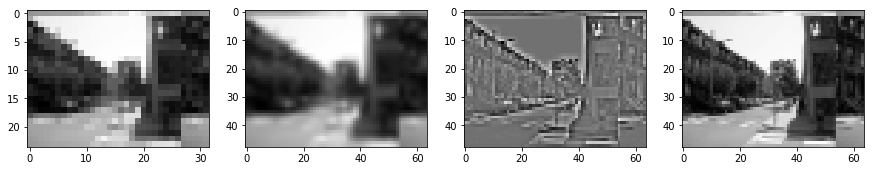

In [7]:
plt.figure(figsize=(15,5))
plt.subplot(1,4,1)
plt.imshow(img_down[0,0,:], cmap='gray')
img_up = interpolate(img_down, size=img_residual.shape[-2:], mode=mode)
plt.subplot(1,4,2)
plt.imshow(img_up[0,0,:], cmap='gray')
plt.subplot(1,4,3)
plt.imshow(img_residual[0,0,:], cmap='gray')
plt.subplot(1,4,4)
plt.imshow(img_up[0,0,:] + img_residual[0,0,:], cmap='gray')

Applying on the central crop of $32\times32$:

In [8]:
img_residual.shape

torch.Size([1, 1, 48, 64])

tensor(0.) tensor(0.9960)
img residual shape= torch.Size([768, 1024])
img_crop shape= torch.Size([1, 5, 32, 32])
tensor(0.0031) tensor(0.9960)
img residual shape= torch.Size([384, 512])
img_crop shape= torch.Size([1, 5, 32, 32])
tensor(0.0091) tensor(0.9931)
img residual shape= torch.Size([192, 256])
img_crop shape= torch.Size([1, 5, 32, 32])
tensor(0.0171) tensor(0.9898)
img residual shape= torch.Size([96, 128])
img_crop shape= torch.Size([1, 5, 32, 32])
tensor(0.0206) tensor(0.9832)
img residual shape= torch.Size([48, 64])
img_crop shape= torch.Size([1, 5, 32, 32])


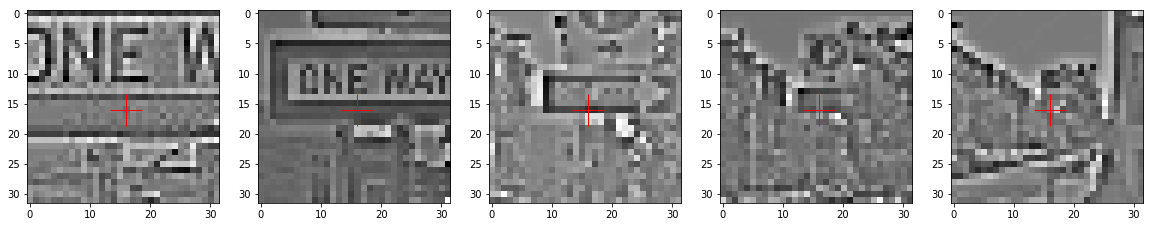

In [9]:
img_down = img_tens.clone()
img_crop = torch.zeros((1, n_level_ref-1, width, width))
img_size = [[]]*(n_level_ref-1)
fig, axs = plt.subplots(1, n_level_ref-1, figsize=(20,20))

#i_level = 1
#while max(img_down.shape) > width :
for i_level, ax in enumerate(axs):
    print(img_down.min(), img_down.max())
    img_residual = img_down.clone()
    img_down = interpolate(img_down, scale_factor=1/base_levels, mode=mode)
    img_residual -= interpolate(img_down, size=img_residual.shape[-2:], mode=mode)
    print('img residual shape=', img_residual.shape[-2:])
    h_res, w_res = img_residual.shape[-2:]
    img_crop[0, i_level, :, :] = img_residual[:, :, 
                        (h_res//2-width//2):(h_res//2+width//2), 
                        (w_res//2-width//2):(w_res//2+width//2)]
    img_size[i_level] = (h_res, w_res)
    ax.imshow(img_crop.numpy()[0, i_level, ...], cmap='gray')
    ax.plot([width/2], [width/2], 'r+', ms=32);
    print('img_crop shape=', img_crop.shape)

torch.Size([1, 1, 24, 32])

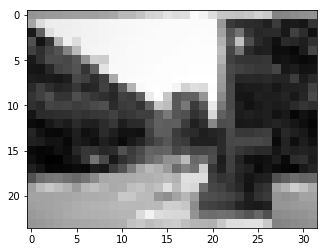

In [10]:
plt.imshow(img_down[0,0,...], cmap='gray')
img_down.shape

In [11]:
n_level_ref

6

torch.Size([32, 32])

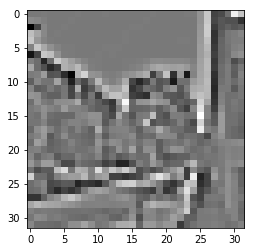

In [12]:
plt.imshow(img_crop[0, n_level_ref-2, :, :], cmap='gray')
img_crop[0, n_level_ref-2, :, :].shape

In [13]:
img_down.size()

torch.Size([1, 1, 24, 32])

(48, 64) (32, 32)
(96, 128) (32, 32)
(192, 256) (32, 32)
(384, 512) (32, 32)
(768, 1024) (32, 32)


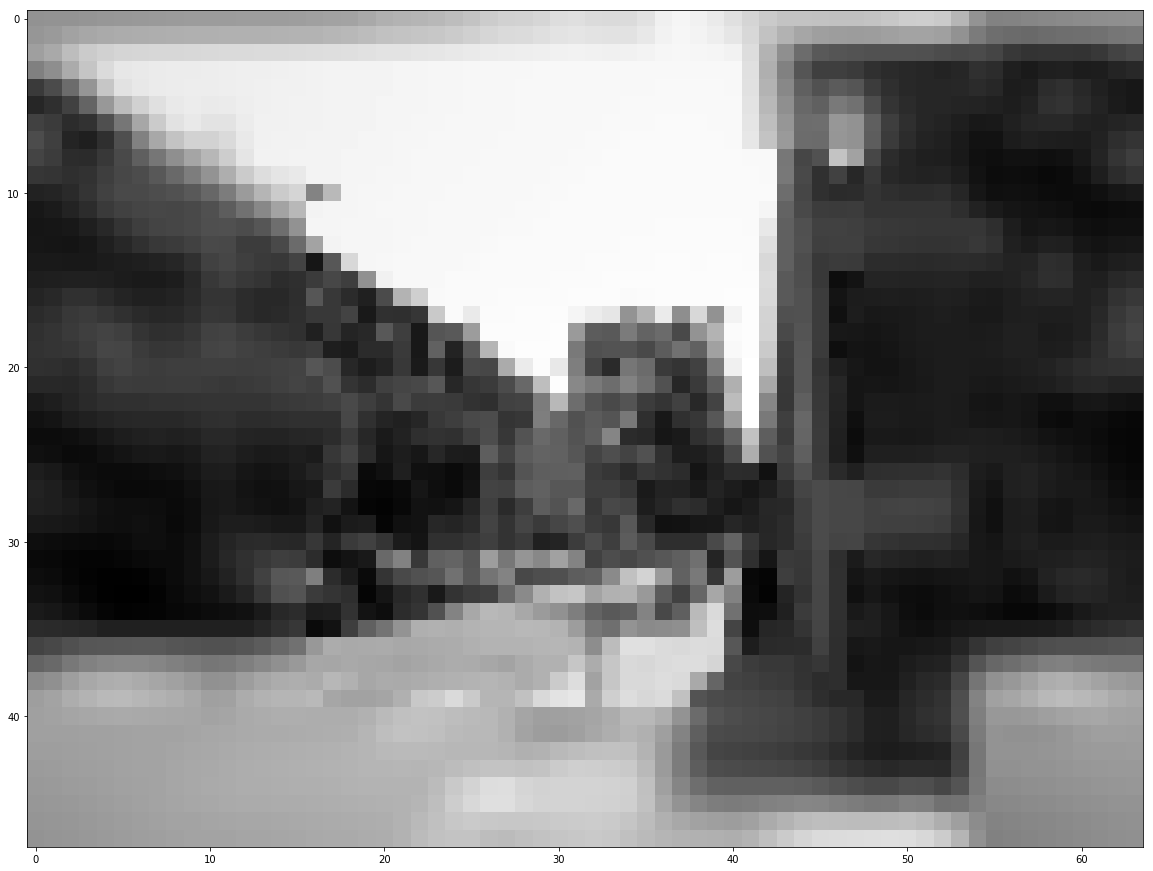

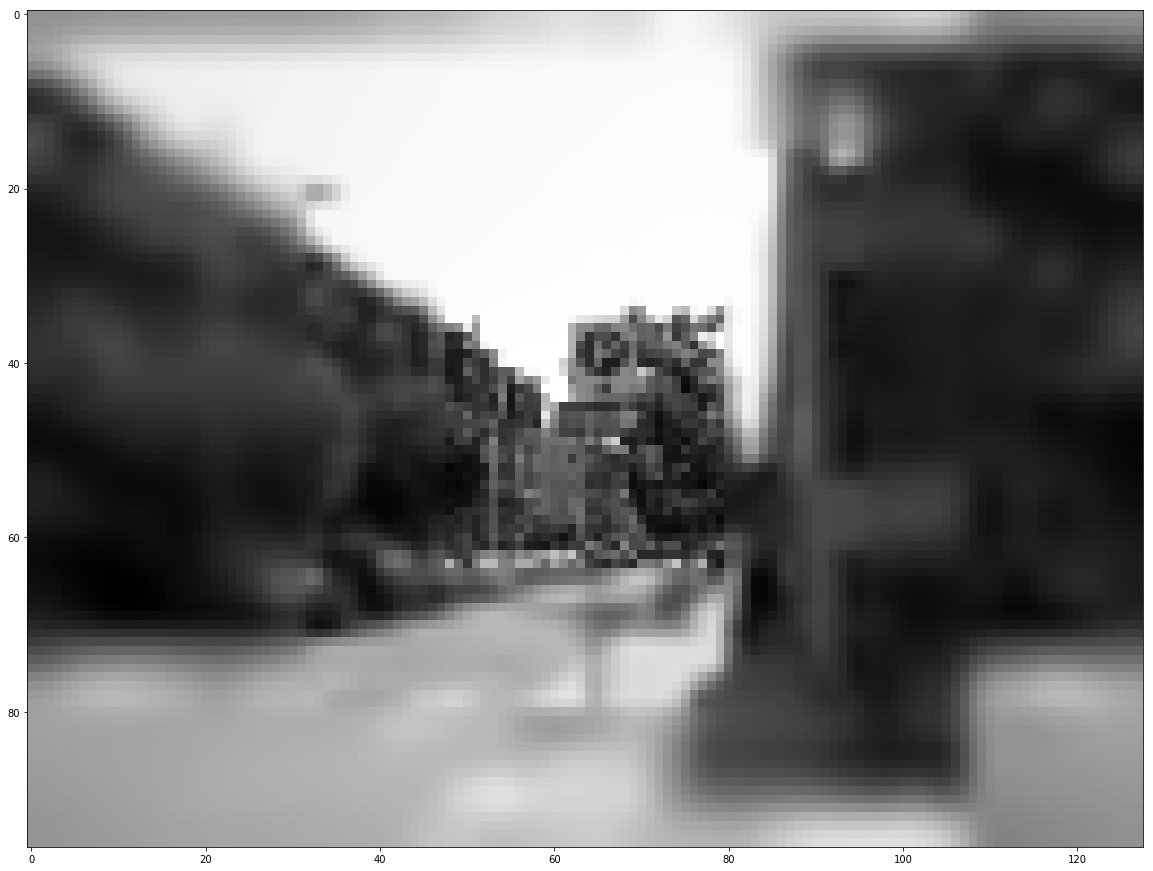

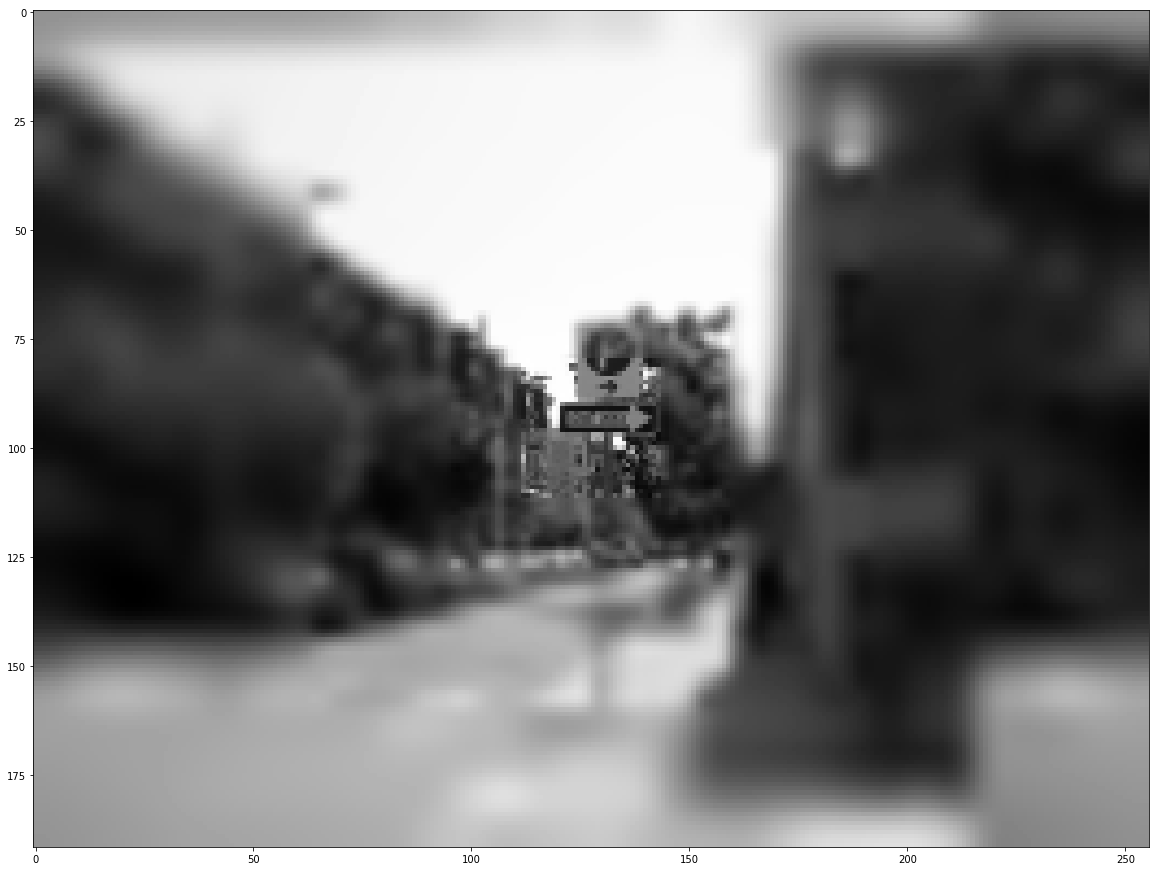

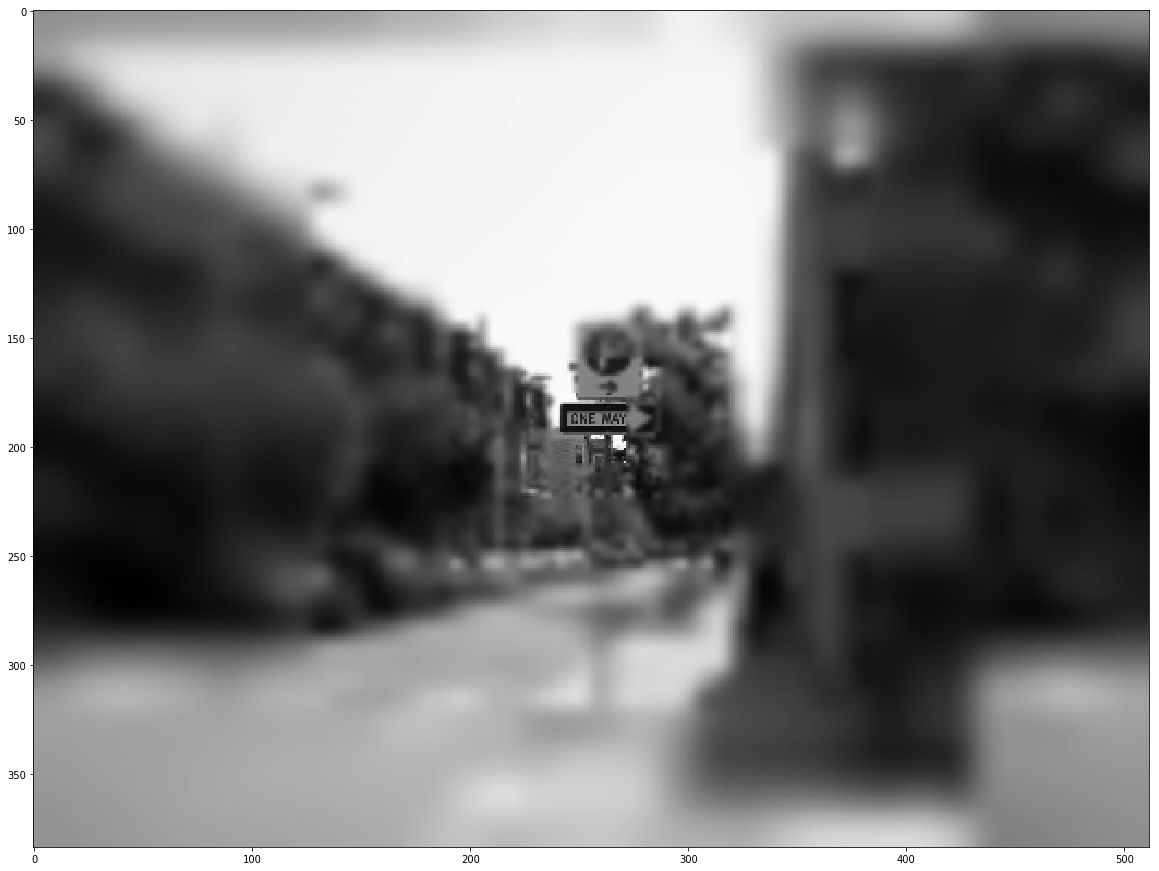

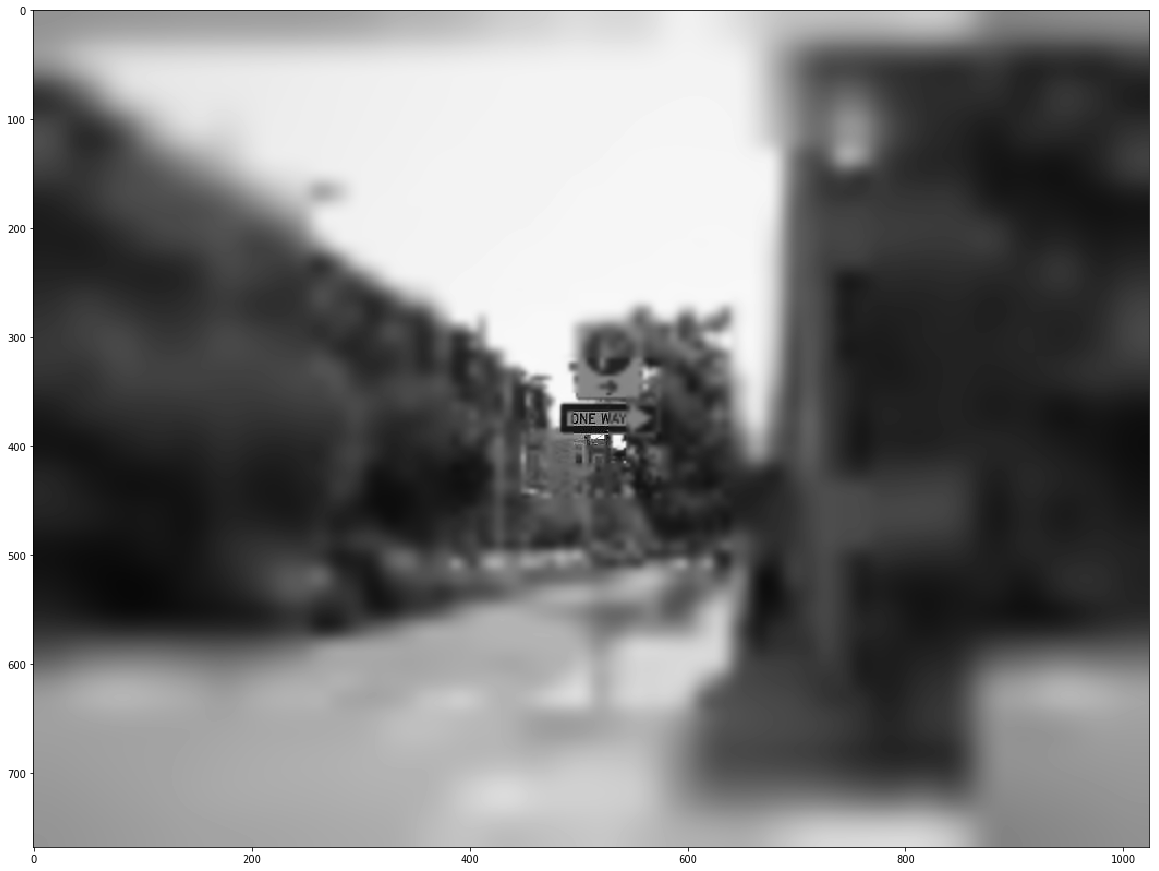

In [14]:
img_up = img_down.clone()

#plt.figure(figsize=(20,20))
#plt.imshow(interpolate(img_down, size=size_up, mode=mode)[0,0,...], cmap='gray')
size_res = (img_crop[0, 0, :, :].shape[0], img_crop[0, 0, :, :].shape[1])
for i in range(2, n_level_ref+1):
    size_up = img_size[n_level_ref-i] #(int(img_up.shape[2]*base_levels), int(img_up.shape[3]*base_levels))   
    img_up = interpolate(img_up, size=size_up, mode=mode)
    
    img_up[0, 0, size_up[0]//2 - size_res[0]//2:size_up[0]//2 + size_res[0]//2,
                 size_up[1]//2 - size_res[1]//2:size_up[1]//2 + size_res[1]//2] += img_crop[0, n_level_ref-i, :, :] 
    print(size_up, size_res)
    #plt.subplot(1,n_levels, i)
    plt.figure(figsize=(20,20))
    plt.imshow(img_up[0,0,...], cmap='gray')
    #img_down = img_up.clone()


In [15]:
 size_res[0]//2

16

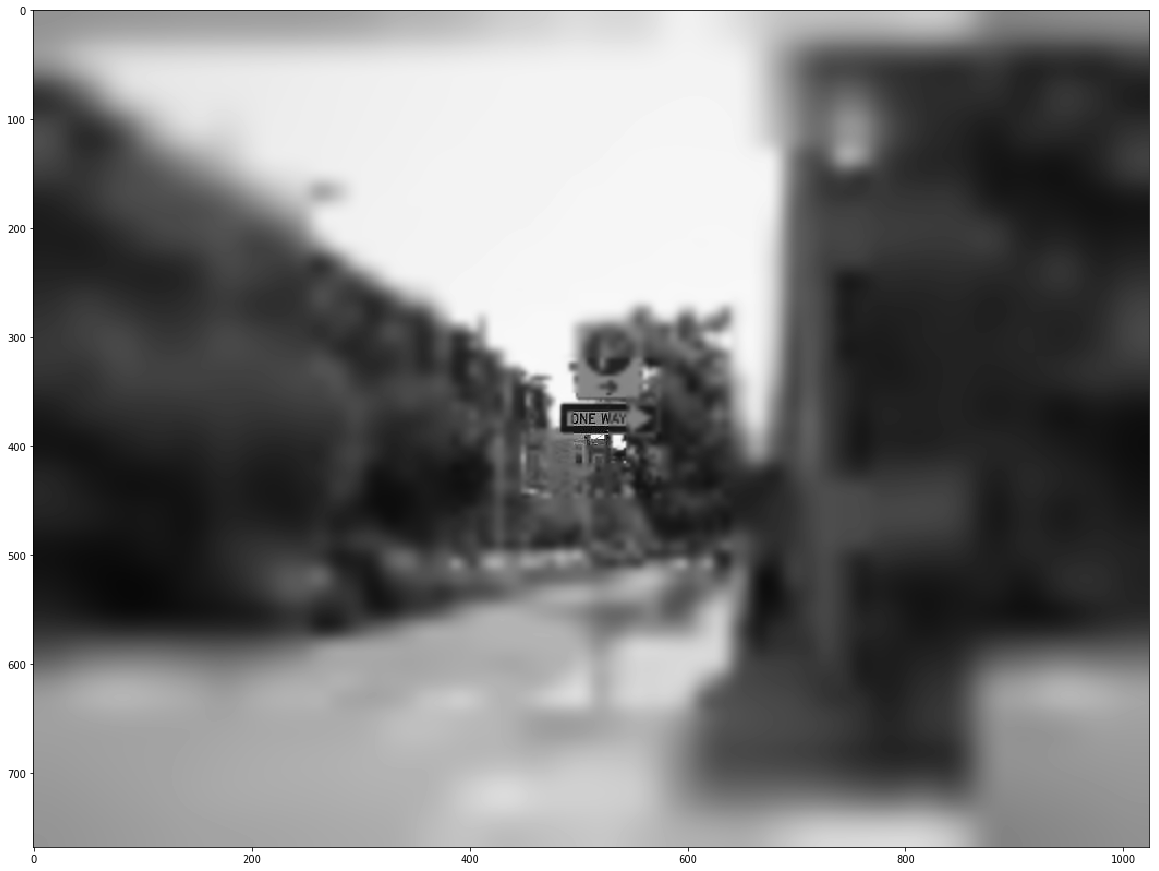

In [16]:
img_up_ref = img_up.clone()
plt.figure(figsize=(20,20))
plt.imshow(img_up_ref[0,0,...], cmap='gray')

Tensor shape= torch.Size([1, 6, 32, 32])


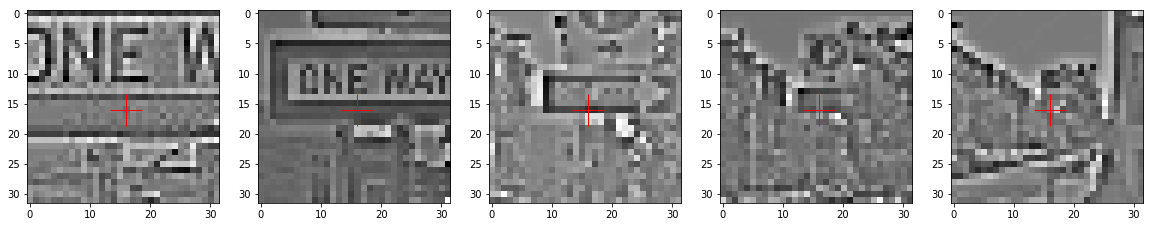

In [17]:
img_down = img_tens
img_crop = torch.zeros((1, n_levels, width, width))
fig, axs = plt.subplots(1, n_levels-1, figsize=(20,20))

for i_level, ax in enumerate(axs):
    img_residual = img_down
    img_down = interpolate(img_down, scale_factor=1/base_levels, mode=mode)
    img_residual -= interpolate(img_down, size=img_residual.shape[-2:], mode=mode)
    
    h_res, w_res = img_residual.shape[-2:]
    img_crop[0, i_level, :, :] = img_residual[:, :, 
                        (h_res//2-width//2):(h_res//2+width//2), 
                        (w_res//2-width//2):(w_res//2+width//2)]
    
    ax.imshow(img_crop.numpy()[0, i_level, ...], cmap='gray')
    ax.plot([width/2], [width/2], 'r+', ms=32);
print('Tensor shape=', img_crop.shape)

## creating a set of filters

In [18]:
from LogGabor import LogGabor
pe = {'N_X': width, 'N_Y': width, 'do_mask': False, 'do_whitening': True,
      'white_name_database': 'kodakdb', 'white_n_learning': 0, 'white_N':
          0.07, 'white_N_0': 0.0, 'white_f_0': 0.4, 'white_alpha': 1.4,
      'white_steepness': 4.0, 'white_recompute': False, 'base_levels':
          base_levels, 'n_theta': 24, 'B_sf': 0.6, 'B_theta': np.pi/12 ,
      'use_cache': True, 'figpath': 'results', 'edgefigpath':
          'results/edges', 'matpath': 'cache_dir', 'edgematpath':
          'cache_dir/edges', 'datapath': 'database/', 'ext': '.pdf', 'figsize':
          14.0, 'formats': ['pdf', 'png', 'jpg'], 'dpi': 450, 'verbose': 0}
lg = LogGabor(pe)
print('lg shape=', lg.pe.N_X, lg.pe.N_Y)

lg shape= 32 32


In [19]:
def local_filter(azimuth, theta, phase, sf_0=.25, radius=width/4):

    x, y = lg.pe.N_X//2, lg.pe.N_Y//2 # center
    x += radius * np.cos(azimuth)
    y += radius * np.sin(azimuth)
    
    return lg.normalize(lg.invert(
        lg.loggabor(x, y, sf_0=sf_0, B_sf=lg.pe.B_sf, theta=theta, B_theta=lg.pe.B_theta) * np.exp(-1j * phase)))

K = local_filter(azimuth=0, theta=0, phase=0, radius=width/4)
print('K shape=', K.shape)
print('K min max=', K.min(), K.max())

K shape= (32, 32)
K min max= -0.4440276868926977 1.0


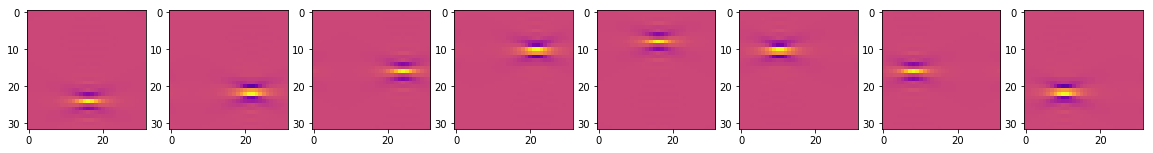

In [20]:
n_test = 8
fig, axs = plt.subplots(1, n_test, figsize=(20,20))
for i_azimuth, ax in enumerate(axs):
    ax.imshow(local_filter(azimuth=i_azimuth*2*np.pi/n_test, 
                           theta=0, phase=0), vmin=-1, vmax=1, cmap='plasma')


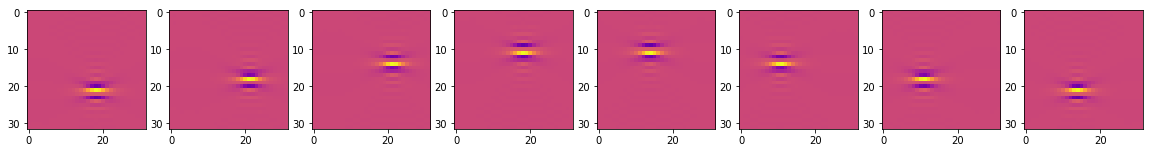

In [21]:
fig, axs = plt.subplots(1, n_test, figsize=(20,20))
for i_azimuth, ax in enumerate(axs):
    ax.imshow(local_filter(azimuth=(i_azimuth+.5)*2*np.pi/n_test, sf_0=.25*np.sqrt(2), 
                           theta=0, phase=0, radius=width/4/np.sqrt(2)), vmin=-1, vmax=1, cmap='plasma')


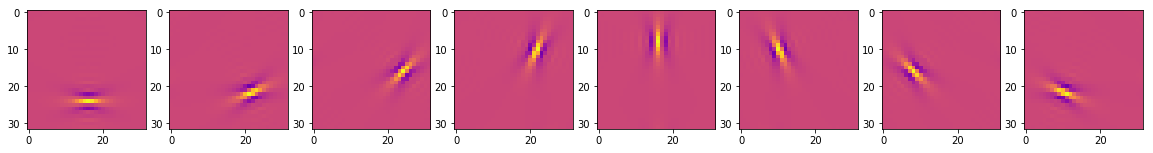

In [22]:
fig, axs = plt.subplots(1, n_test, figsize=(20,20))
for i_azimuth, ax in enumerate(axs):
    ax.imshow(local_filter(azimuth=i_azimuth*2*np.pi/n_test, 
                           theta=i_azimuth*np.pi/n_test, phase=0), vmin=-1, vmax=1, cmap='plasma')


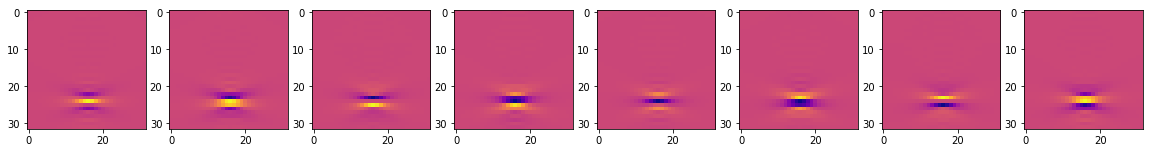

In [23]:
fig, axs = plt.subplots(1, n_test, figsize=(20,20))
for i_phase, ax in enumerate(axs):
    ax.imshow(local_filter(azimuth=0, theta=0, phase=i_phase*2*np.pi/n_test), vmin=-1, vmax=1, cmap='plasma')


## !! Ajout de sous-levels (honeybee)

In [24]:
n_sublevel = 2
n_azimuth = 12
n_theta = 12
n_phase = 2

K = np.zeros((width, width, n_sublevel, n_azimuth, n_theta, n_phase))
for i_sublevel in range(n_sublevel):
    sf_0 = .25*(np.sqrt(2)**i_sublevel)
    radius = width/4/(np.sqrt(2)**i_sublevel)
    print('i_sublevel, sf_0, radius', i_sublevel, sf_0, radius)
    for i_azimuth in range(n_azimuth):
        for i_theta in range(n_theta):
            for i_phase in range(n_phase):
                K[..., i_sublevel, i_azimuth, i_theta, i_phase] = local_filter(azimuth=(i_azimuth+i_sublevel/2)*2*np.pi/n_azimuth, 
                                                                               theta=i_theta*np.pi/n_theta, 
                                                                               phase=i_phase*np.pi/n_phase, sf_0=sf_0, radius=radius)
print('K shape=', K.shape)
print('K min max=', K.min(), K.max())

i_sublevel, sf_0, radius 0 0.25 8.0
i_sublevel, sf_0, radius 1 0.3535533905932738 5.65685424949238
K shape= (32, 32, 2, 12, 12, 2)
K min max= -1.0 1.0


In [25]:
K_ = torch.Tensor(K)
print('Tensor shape=', K_.shape)

Tensor shape= torch.Size([32, 32, 2, 12, 12, 2])


## Visual field covering

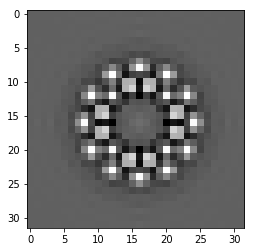

In [26]:
coefs = np.zeros((n_sublevel, n_azimuth, n_theta, n_phase))
coefs[:, :, :, 0] = np.ones((n_sublevel, n_azimuth, n_theta))
coefs_tf = torch.Tensor(coefs)
img_dis = torch.tensordot(K_, coefs_tf, dims=4)
plt.imshow(img_dis.numpy()[:, :, ...], cmap='gray')

In [27]:
img_size

[(768, 1024), (384, 512), (192, 256), (96, 128), (48, 64)]

In [28]:
n_levels

6

torch.Size([1, 1, 48, 48])
torch.Size([1, 1, 96, 96])
torch.Size([1, 1, 192, 192])
torch.Size([1, 1, 384, 384])
torch.Size([1, 1, 768, 768])
torch.Size([1, 1, 48, 48])


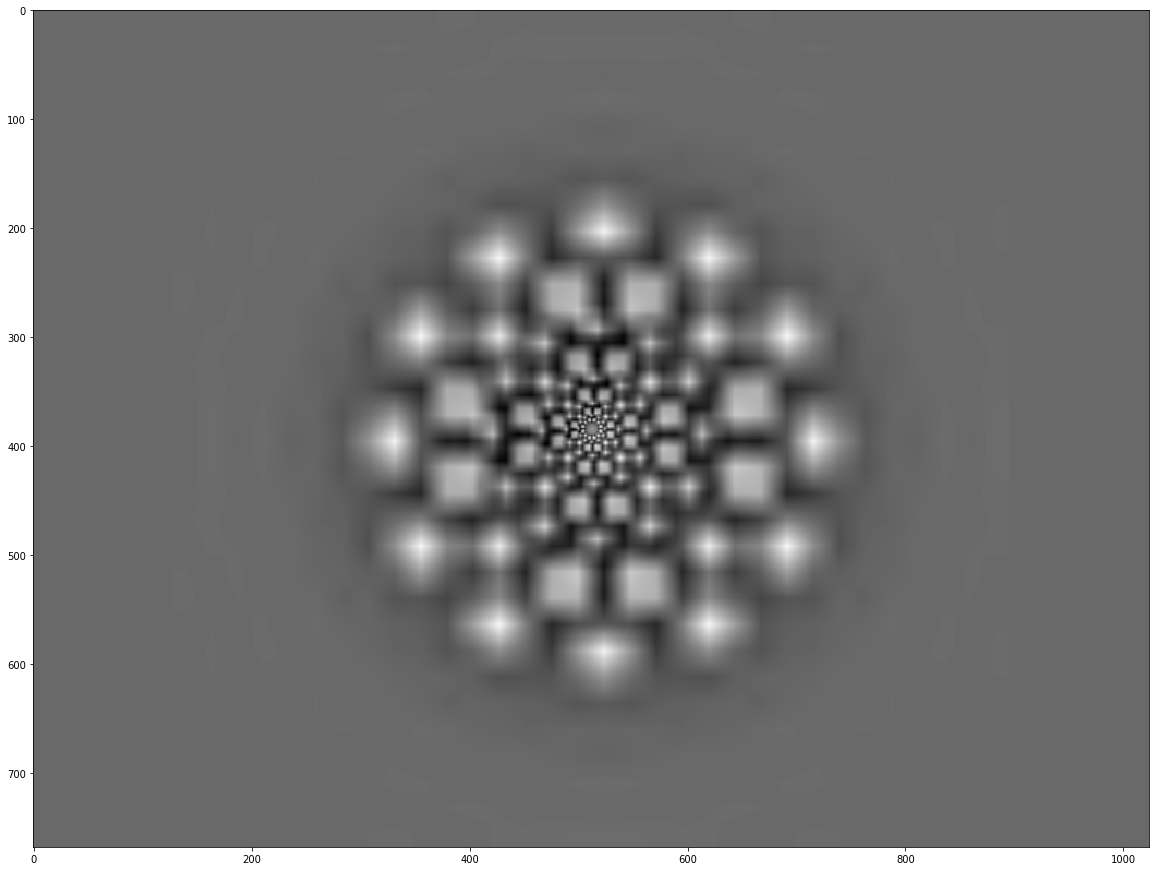

In [50]:
coefs = np.zeros((n_sublevel, n_azimuth, n_theta, n_phase))
coefs[:, :, :, 0] = np.ones((n_sublevel, n_azimuth, n_theta))
coefs_tf = torch.Tensor(coefs)
img_dis = torch.tensordot(K_, coefs_tf, dims=4)
levels = n_level_ref #6 #
img_up = {}
for lev in range(levels):
    side = img_size[n_level_ref-2-lev][0]
    #img_up[lev] = interpolate(img_dis[None,None, ...], size = (32*2**lev, 32*2**lev), mode=mode)
    img_up[lev] = interpolate(img_dis[None,None, ...], size = (side, side), mode=mode)
    print(img_up[lev].shape)
    #plt.figure()
    #plt.imshow(img_up[lev][0,0,...])
#img_up[lev].shape
img = img_up[levels-2]
side_ref = img.shape[2] #img_size[0][0]
for lev in range(levels-1):
    #side = img_size[n_level_ref-2-lev][0]
    #img[:,:,2**9-2**(lev+4):2**9+2**(lev+4), 2**9-2**(lev+4):2**9+2**(lev+4)] += img_up[lev]
    side_in = img_up[lev].shape[-2:][0]
    b_inf = side_ref//2 - side_in//2
    img[:,:,b_inf : b_inf+side_in, b_inf : b_inf+side_in] += img_up[lev]
plt.figure(figsize=(20,20))
#plt.imshow(img.numpy()[0, 0, 2**8:3*2**8,2**8:3*2**8], cmap='gray')
img_cov = torch.zeros((1,1,N_X, N_Y))
side_in = img.shape[3]
img_cov[0, 0, N_X//2 - side_in//2:N_X//2 + side_in//2,
               N_Y//2 - side_in//2:N_Y//2 + side_in//2] += img[0,0,...]
    
plt.imshow(img_cov[0,0,...], cmap='gray')

## Applying the filter

In [30]:
print('Tensor shape=', img_crop.shape)

Tensor shape= torch.Size([1, 6, 32, 32])


In [31]:
%%timeit
out = torch.tensordot(img_crop, K_,  dims=2)

143 µs ± 33.6 µs per loop (mean ± std. dev. of 7 runs, 10000 loops each)


In [32]:
out = torch.tensordot(img_crop, K_,  dims=2)
print('Tensor shape=', out.shape)

Tensor shape= torch.Size([1, 6, 2, 12, 12, 2])


In [33]:
np.prod(img_crop.shape), np.prod(out.shape)

(6144, 3456)

## Reconstruction of cropped central images

### Layer by layer

Tensor shape= torch.Size([1, 6, 32, 32])


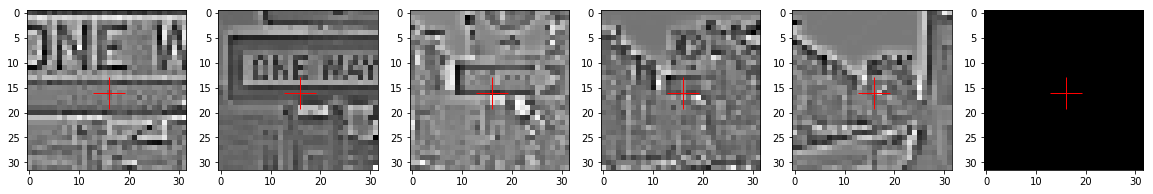

In [34]:
fig, axs = plt.subplots(1, n_levels, figsize=(20,20))
for i_level, ax in enumerate(axs):
    ax.imshow(img_crop.numpy()[0, i_level, ...], cmap='gray')
    ax.plot([width/2], [width/2], 'r+', ms=32);
print('Tensor shape=', img_crop.shape)

In [35]:
print('Tensor shape=', K_.shape)
K__ = K_.reshape((width**2, n_sublevel*n_azimuth*n_theta*n_phase))
print('Tensor shape=', K__.shape)

Tensor shape= torch.Size([32, 32, 2, 12, 12, 2])
Tensor shape= torch.Size([1024, 576])


In [36]:
print('Tensor shape=', out.shape)
out__ = out.reshape((1, n_levels, n_sublevel*n_azimuth*n_theta*n_phase))
print('Tensor shape=', out__.shape)

Tensor shape= torch.Size([1, 6, 2, 12, 12, 2])
Tensor shape= torch.Size([1, 6, 576])


In [37]:
K_inv = torch.pinverse(K__)
print('Tensor shape=', K_inv.shape)

Tensor shape= torch.Size([576, 1024])


In [38]:
img_rec =  torch.tensordot(out__, K_inv,  dims=1).reshape((1, n_levels, width, width))
print('Tensor shape=', img_rec.shape)

Tensor shape= torch.Size([1, 6, 32, 32])


Tensor shape= torch.Size([1, 6, 32, 32])


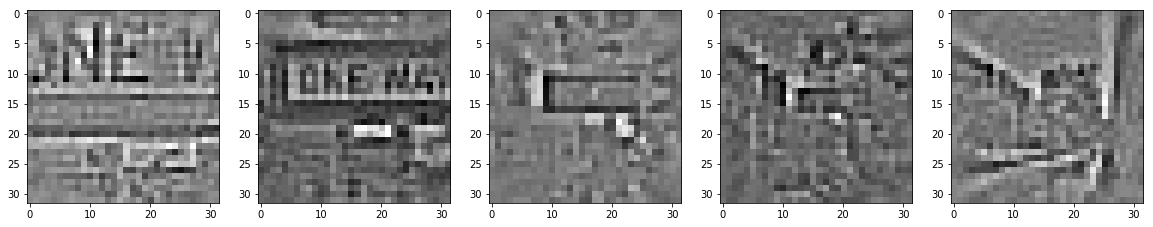

In [39]:
fig, axs = plt.subplots(1, n_levels-1, figsize=(20,20))
for i_level, ax in enumerate(axs):
    ax.imshow(img_rec.numpy()[0, i_level, ...], cmap='gray')
print('Tensor shape=', img_crop.shape)

(48, 64) (32, 32)
(96, 128) (32, 32)
(192, 256) (32, 32)
(384, 512) (32, 32)
(768, 1024) (32, 32)


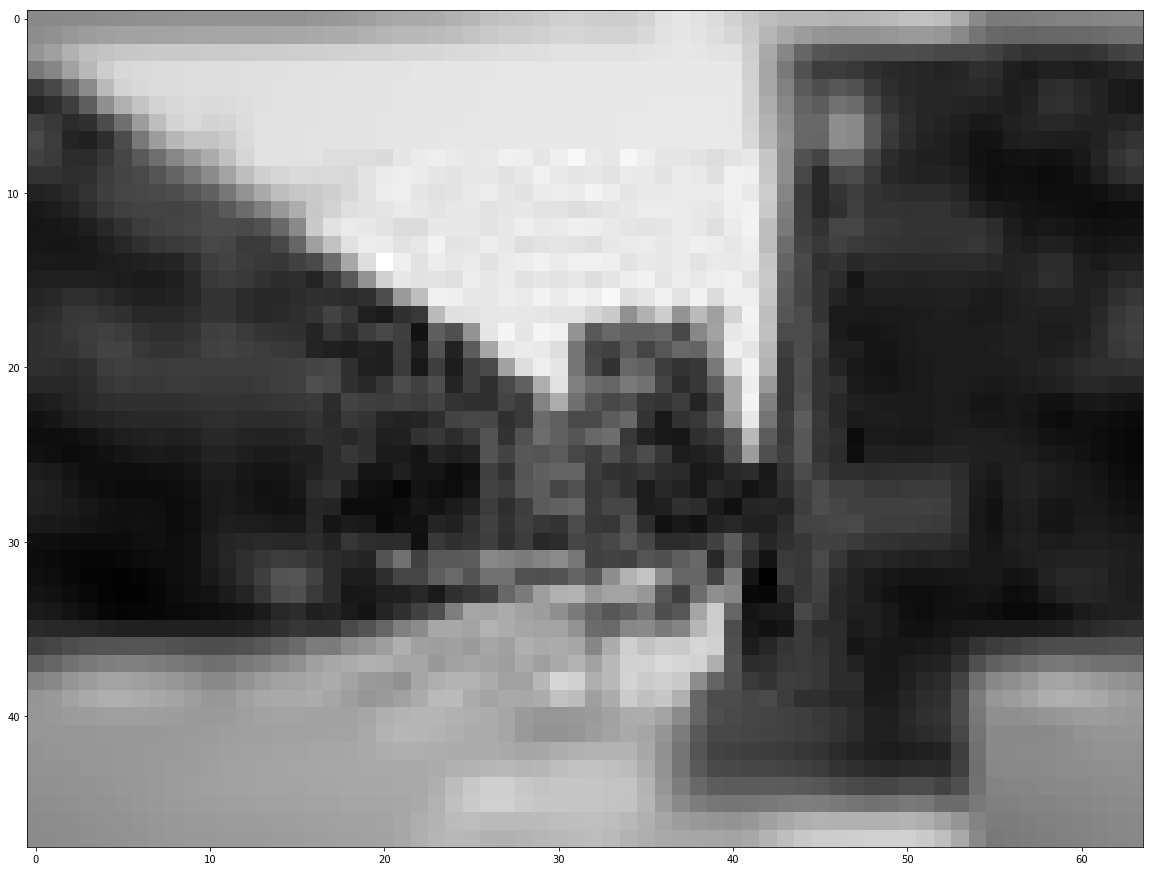

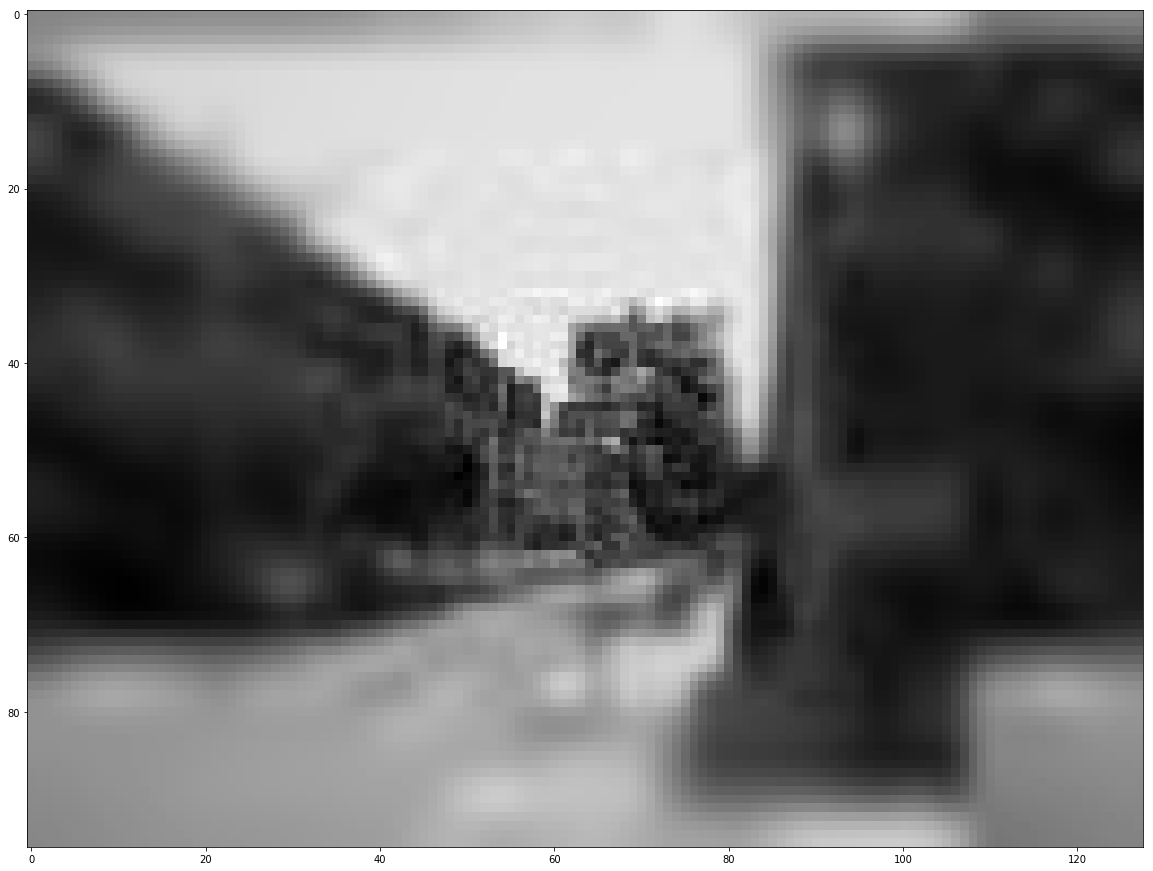

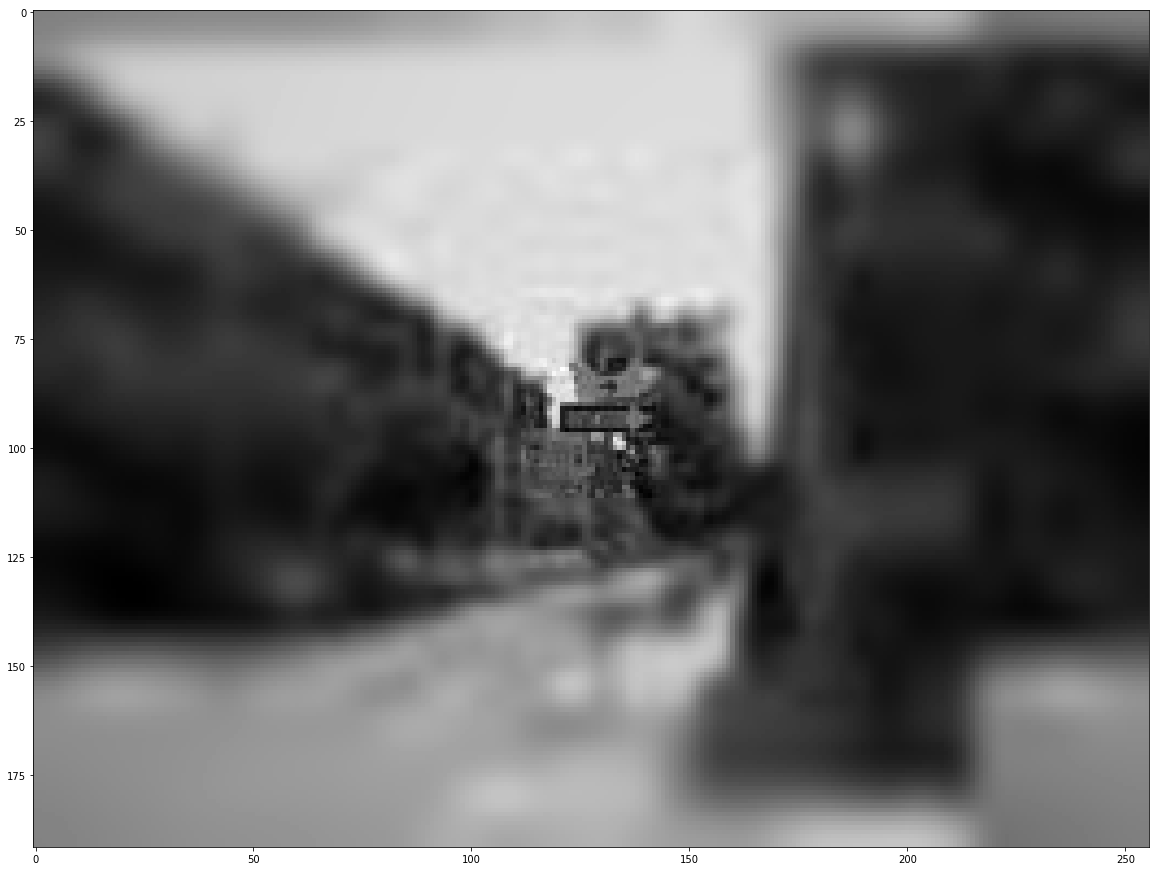

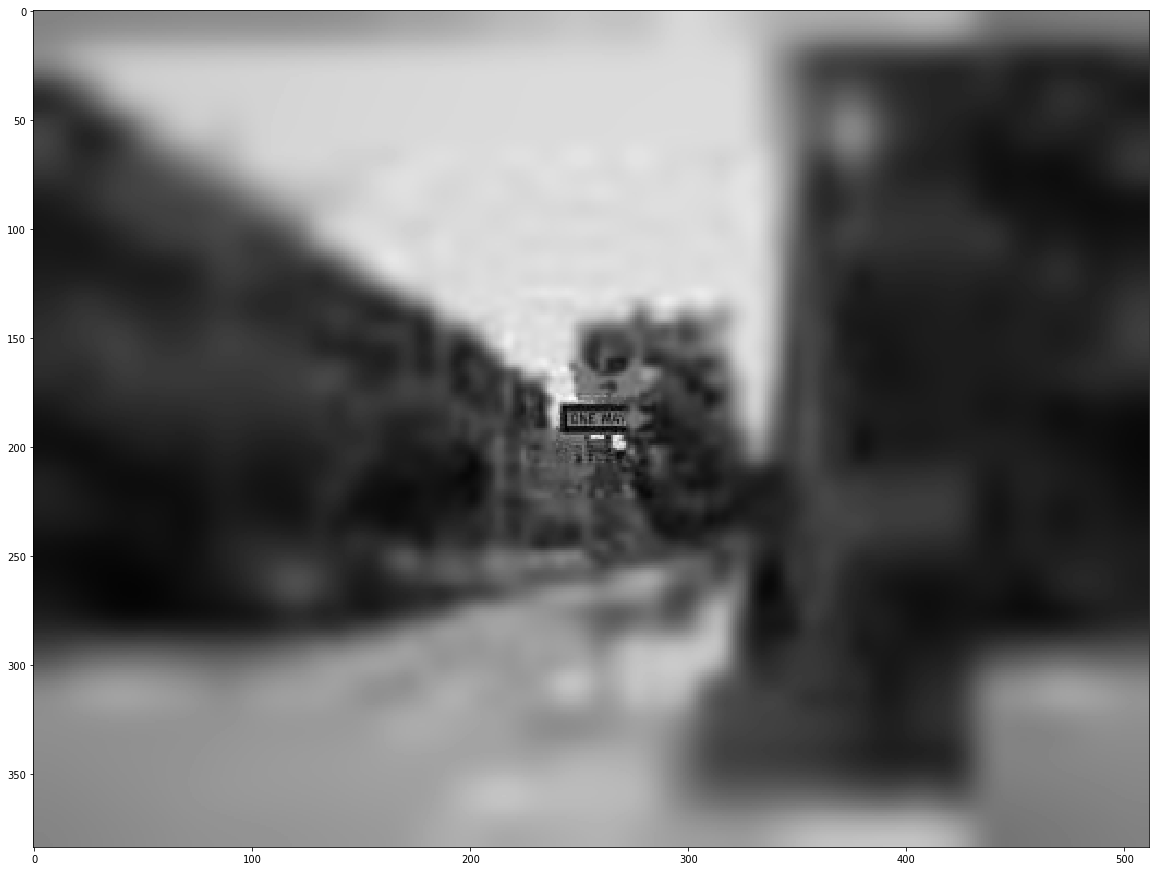

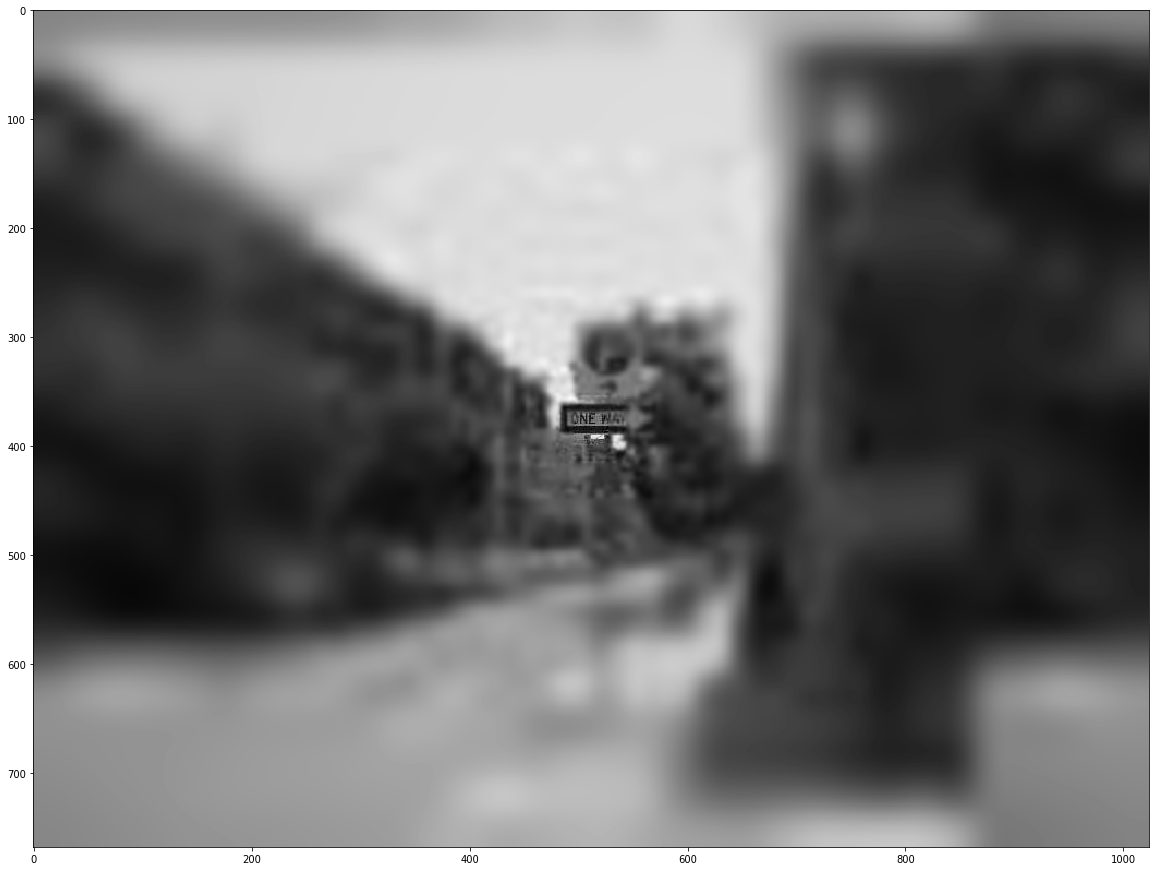

In [40]:
img_up_lg = img_down.clone()
#img_up_lg = torch.zeros_like(img_down.clone())

#plt.figure(figsize=(20,20))
#plt.imshow(interpolate(img_down, size=size_up, mode=mode)[0,0,...], cmap='gray')
for i in range(2, n_levels+1):
    size_up = img_size[n_level_ref-i] # (int(img_up_lg.shape[2]*base_levels), int(img_up_lg.shape[3]*base_levels))
    size_rec = (img_rec[0, n_levels-i, :, :].shape[0], img_rec[0, n_levels-i, :, :].shape[1])
    img_up_lg = interpolate(img_up_lg, size=size_up, mode=mode)
    
    img_up_lg[0, 0, size_up[0]//2 - size_rec[0]//2:size_up[0]//2 + size_rec[0]//2,
                    size_up[1]//2 - size_rec[1]//2:size_up[1]//2 + size_rec[1]//2] += img_rec[0, n_levels-i, :, :] 
    print(size_up, size_rec)
    plt.figure(figsize=(20,20))
    plt.imshow(img_up_lg[0,0,...], cmap='gray')
    #plt.subplot(1,n_levels, i)
    #plt.imshow(img_up_lg[0,0,...], cmap='gray')
    #img_down = img_up_lg.clone()


Text(0.5, 1.0, 'LOGPOL+PYRAMID')

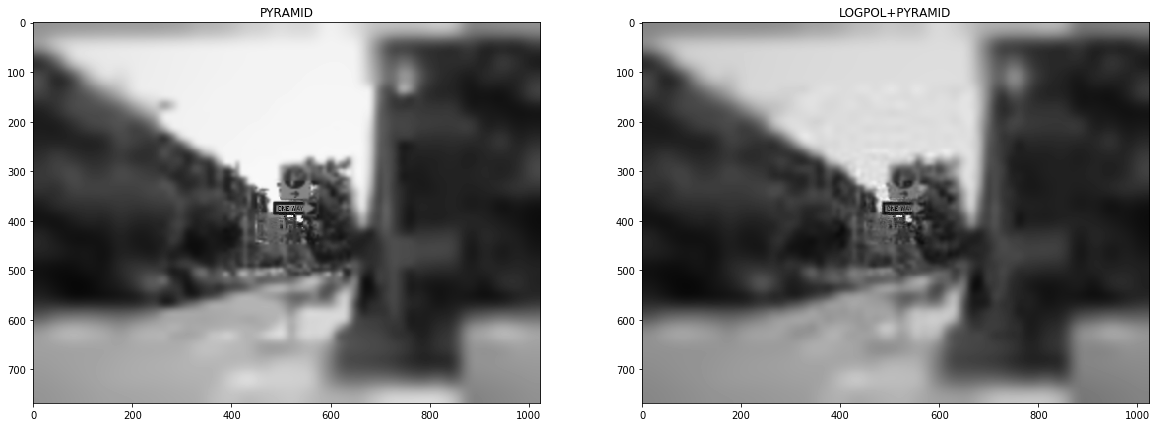

In [45]:
plt.figure(figsize=(20,20))
plt.subplot(1,2,1)
plt.imshow(img_up_ref[0,0,...], cmap='gray')
plt.title('PYRAMID')
plt.subplot(1,2,2)
plt.imshow(img_up_lg[0,0,...], cmap='gray')
plt.title('LOGPOL+PYRAMID')



(768, 1024)

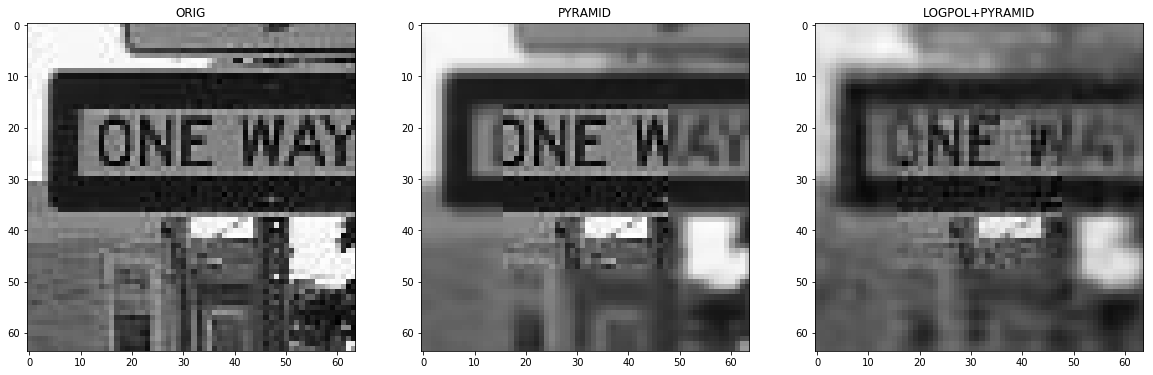

In [44]:
plt.figure(figsize=(20,20))
plt.subplot(1,3,1)
plt.imshow(img_orig[N_X//2-32:N_X//2+32, 
                    N_Y//2-32:N_Y//2+32], cmap='gray')
plt.title('ORIG')
plt.subplot(1,3,2)
plt.imshow(img_up_ref[0,0,N_X//2-32:N_X//2+32, 
                          N_Y//2-32:N_Y//2+32], cmap='gray')
plt.title('PYRAMID')
plt.subplot(1,3,3)
plt.imshow(img_up_lg[0,0,N_X//2-32:N_X//2+32, 
                         N_Y//2-32:N_Y//2+32], cmap='gray')
plt.title('LOGPOL+PYRAMID')
N_X, N_Y

In [ ]:
plt.plot(out__[:,:5,:].flatten().numpy())
plt.plot(img_down.flatten().numpy())


### all layers at once ?

Would require learning ...